In [107]:
import numpy as np
import sys
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import interferometer as itf
sys.path.append('../') # Add parent directory to the system path
from boson_sampling_probabilities import output_probability
from simulation import run_interferom_simulation, dist_to_state

from numeric_truncated_unitaries import numeric_truncated_unitary
from direct_decomposition import compile_unitary, knit_qiskit_circuits, random_unitary
from random import random

In [108]:
def is_unitary(m):
    return np.allclose(np.eye(m.shape[0]), np.conjugate(np.transpose(m)) @ m)

# Useful diagnostics, don't delete

# R = random_unitary(3)
# assert(is_unitary(R))
# I = itf.square_decomposition(R)
# T = I.calculate_transformation()

# print(R)
# print("\n")
# assert(is_unitary(R))
# assert(np.allclose(R,T))

[
 Beam splitter between modes 1 and 2: 
 Theta angle: 0.69 
 Phase: 2.28, 
 Beam splitter between modes 2 and 3: 
 Theta angle: 1.03 
 Phase: 2.80]


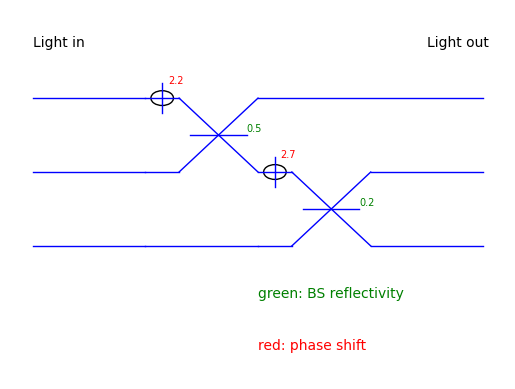

In [160]:
"""
Some notes:
    theta = 0 -> reflective.
    theta = pi/2 -> transparent
    R = 0 -> transparent
    R = 1 -> reflective
"""

I = itf.Interferometer()

theta_1 = np.pi/2 * random()
phi_1 = np.pi * random()
theta_2 = np.pi/2 * random()
phi_2 = np.pi * random()

BS1 = itf.Beamsplitter(1, 2, theta=theta_1, phi=phi_1)
BS2 = itf.Beamsplitter(2, 3, theta=theta_2, phi=phi_2)

I.add_BS(BS1)
I.add_BS(BS2)

print(I.BS_list)
I.draw()

In [161]:
R=I.calculate_transformation()
print(R)
is_unitary(R)

[[-0.49879111+0.58634436j -0.63828498+0.j          0.        +0.j        ]
 [ 0.11548084-0.30571579j -0.37108119+0.13281963j -0.85898762+0.j        ]
 [ 0.19374477-0.51290614j -0.62257112+0.22283443j  0.51199636+0.j        ]]


True

In [162]:
initial_dist = [1,0,0]
possible_dists = [[1,0,0], [0,1,0], [0,0,1]] # Every configuration of 1 photon in 3 modes

analytic_probs = dict()
for dist in possible_dists:
    assert(is_unitary(R))
    # prob = output_probability([1,0,0], dist, R)
    # This is what was going wrong I was putting in incorrect arguments
    # I was iterating over output distributions, not input distributions!
    prob = output_probability(initial_dist, dist, R)
    state = dist_to_state(dist)
    analytic_probs[state] = prob

print(analytic_probs)

{'100': 0.5925922855880741, '010': 0.10679796931167791, '001': 0.300609745100248}


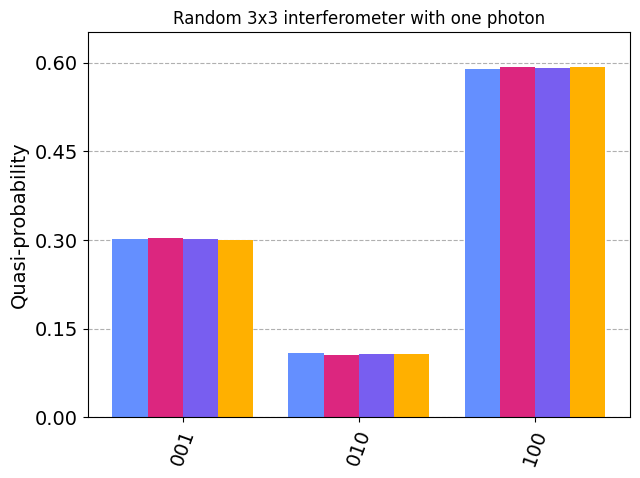

In [163]:
probs_1e3 = run_interferom_simulation(R, initial_dist, 1e3)
probs_1e4 = run_interferom_simulation(R, initial_dist, 1e4)
probs_1e5 = run_interferom_simulation(R, initial_dist, 1e5)

legend = ['Shots = 1e3','Shots = 1e4','Shots = 1e5', 'Analytic results']
plot_histogram([probs_1e3, probs_1e4, probs_1e5, analytic_probs], 
               title='Random 3x3 interferometer with one photon', bar_labels=False)

In [117]:
# def custom_calculate_transformation():

#     def Beamsplitter(theta, phi):
#         return np.matrix(
#             [[np.exp(1j*phi) * np.cos(theta), -np.sin(theta)], 
#              [np.exp(1j*phi) * np.sin(theta), np.cos(theta)]]
#              )

#     I2 = np.eye(2,2)
#     BSM1 = Beamsplitter(BS1.theta, BS1.phi) 
#     BSM2 = Beamsplitter(BS2.theta, BS2.phi)

#     padded_BSM1 = np.pad(BSM1, ((0,1),(0,1)), 'constant', constant_values=0)
#     padded_BSM2 = np.pad(BSM2, ((1,0),(1,0)), 'constant', constant_values=0)
#     padded_BSM1[2,2] = 1
#     padded_BSM2[0,0] = 1
#     return padded_BSM1 @ padded_BSM2 

# R = custom_calculate_transformation()

## 2 photon experiment

In [142]:
initial_dist = [2,0,0]
possible_dists = [[2,0,0], [0,2,0], [0,0,2], [1,1,0], [1,0,1], [0,1,1]] # Every configuration of 1 photon in 3 modes

analytic_probs = dict()
for dist in possible_dists:
    assert(is_unitary(R))
    # prob = output_probability([1,0,0], dist, R)
    prob = output_probability(initial_dist, dist, R)
    state = dist_to_state(dist)
    analytic_probs[state] = prob

print(analytic_probs)

{'100000': 0.3492276626591696, '001000': 8.615105186682099e-05, '000010': 0.15981074982170296, '010100': 0.010970201544015278, '010001': 0.4724842203843114, '000101': 0.007421014538933363}


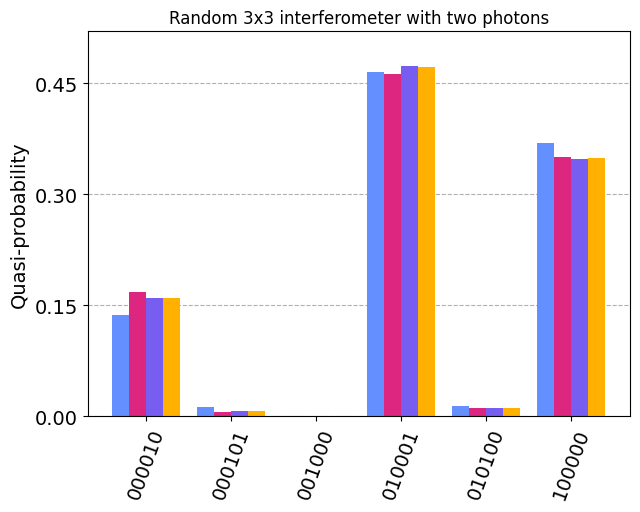

In [143]:
probs_1e3 = run_interferom_simulation(R, initial_dist, 1e3)
probs_1e4 = run_interferom_simulation(R, initial_dist, 1e4)
probs_1e5 = run_interferom_simulation(R, initial_dist, 1e5)

legend = ['Shots = 1e3','Shots = 1e4','Shots = 1e5', 'Analytic results']
plot_histogram([probs_1e3, probs_1e4, probs_1e5, analytic_probs], 
               title='Random 3x3 interferometer with two photons', bar_labels=False)

# Random unitary test (Failing)

In [120]:
U = random_unitary(3)
print(U)
assert(is_unitary(U))


[[ 0.34579471-0.52391549j  0.45322647+0.11381632j  0.44709754+0.43321356j]
 [ 0.36027016+0.54308795j  0.60581409-0.11493958j  0.16846153-0.40823987j]
 [-0.42558928+0.00855829j  0.58963822-0.23181147j -0.54128056+0.35271247j]]


In [129]:
initial_dist = [1,0,0]
possible_dists = [[1,0,0], [0,1,0], [0,0,1]] # Every configuration of 1 photon in 3 modes

analytic_probs = dict()
for dist in possible_dists:
    assert(is_unitary(U))
    # prob = output_probability([1,0,0], dist, R)
    # This is what was going wrong I was putting in incorrect arguments
    # I was iterating over output distributions, not input distributions!
    prob = output_probability([1,0,0], dist, U)
    state = dist_to_state(dist)
    analytic_probs[state] = prob

print(analytic_probs)

{'100': 0.3940614142357317, '010': 0.42473910609350934, '001': 0.18119947967075906}


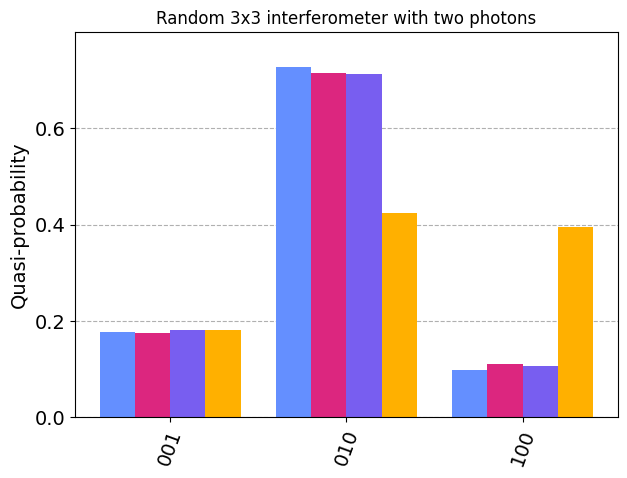

In [130]:
probs_1e3 = run_interferom_simulation(U, initial_dist, 1e3)
probs_1e4 = run_interferom_simulation(U, initial_dist, 1e4)
probs_1e5 = run_interferom_simulation(U, initial_dist, 1e5)

legend = ['Shots = 1e3','Shots = 1e4','Shots = 1e5', 'Analytic results']
plot_histogram([probs_1e3, probs_1e4, probs_1e5, analytic_probs], 
               title='Random 3x3 interferometer with two photons', bar_labels=False)

# Reverse two knit test

[
 Beam splitter between modes 2 and 3: 
 Theta angle: 0.43 
 Phase: 0.51, 
 Beam splitter between modes 1 and 2: 
 Theta angle: 1.27 
 Phase: 0.66]


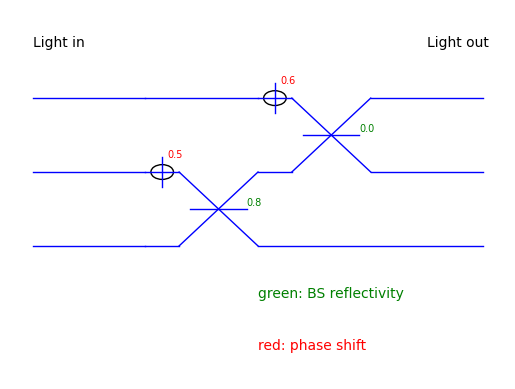

In [170]:
I = itf.Interferometer()

theta_1 = np.pi/2 * random()
phi_1 = np.pi * random()
theta_2 = np.pi/2 * random()
phi_2 = np.pi * random()

BS1 = itf.Beamsplitter(2, 3, theta=theta_1, phi=phi_1)
BS2 = itf.Beamsplitter(1, 2, theta=theta_2, phi=phi_2)

I.add_BS(BS1)
I.add_BS(BS2)

print(I.BS_list)
I.draw()

In [171]:
R=I.calculate_transformation()
print(R)
is_unitary(R)

initial_dist = [1,0,0]
possible_dists = [[1,0,0], [0,1,0], [0,0,1]] # Every configuration of 1 photon in 3 modes

analytic_probs = dict()
for dist in possible_dists:
    assert(is_unitary(R))
    # prob = output_probability([1,0,0], dist, R)
    # This is what was going wrong I was putting in incorrect arguments
    # I was iterating over output distributions, not input distributions!
    prob = output_probability(initial_dist, dist, R)
    state = dist_to_state(dist)
    analytic_probs[state] = prob

print(analytic_probs)

[[ 0.23558051+0.18228918j -0.75691955-0.4236701j   0.39855855+0.j        ]
 [ 0.75497803+0.58419231j  0.23618634+0.13220043j -0.12436472+0.j        ]
 [ 0.        +0.j          0.36432295+0.20392226j  0.90867183+0.j        ]]
{'100': 0.08872752274672865, '010': 0.9112724772532715, '001': 0.0}


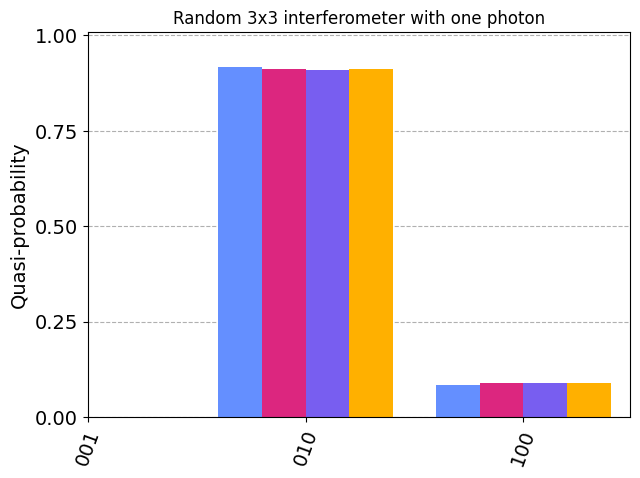

In [172]:
probs_1e3 = run_interferom_simulation(R, initial_dist, 1e3)
probs_1e4 = run_interferom_simulation(R, initial_dist, 1e4)
probs_1e5 = run_interferom_simulation(R, initial_dist, 1e5)

legend = ['Shots = 1e3','Shots = 1e4','Shots = 1e5', 'Analytic results']
plot_histogram([probs_1e3, probs_1e4, probs_1e5, analytic_probs], 
               title='Random 3x3 interferometer with one photon', bar_labels=False)